In [7]:
import numpy as np 
from scipy.integrate import quad 
import os
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from pathos.multiprocessing import ProcessingPool
from functools import partial
from matplotlib.colors import LogNorm
import pandas as pd
import datetime

In [24]:
def phi_0(k: np.array) -> float:
    k_length = np.sqrt(k[0]**2 + k[1]**2 + k[2]**2)
    # hydrogen_100 = 1 / (np.sqrt(np.pi) * c.a0.value**(3/2)) * np.exp(-r_size / c.a0.value)
    # tot_phi_0 = 1 / (2 * np.pi)**(3/2)
    solution = 2 ** (3/2) / np.pi / (1 + k_length**2)**2
    return solution


def A_x(t, T, w, phase, eplison, A_0) -> float:
    val = A_0 / np.sqrt(1 + eplison**2) * np.sin(np.pi * t / T)**2 * np.cos(w * t + phase)
    return val


def A_y(t, T, w, phase, eplison, A_0) -> float:
    val = A_0 / np.sqrt(1 + eplison**2) * np.sin(np.pi * t / T)**2 * eplison * np.cos(w * t + phase)
    return val


def M_SFA_VG_old(t_f: float, t_0: float, k: np.array, w_sim: float,
             A_0: float, E_0: float, phase: float, epsilon: float, T_f: float, 
             #sin4cos2, sin4sin2, sin2cos, sin2sin
            ) -> float:
    """
    sin4cos2 and sin4sin2 needs to be the integral and type Piecewise 
    """
    
    i = complex(0, 1)
    
    k_squared = k[0]**2 + k[1]**2 + k[2]**2
    
    # I need to make for kx and ky
    
    test_sin4cos2 = lambda time: np.sin(np.pi * time / T_s)**4 * np.cos(w_s * time + phase_s)**2
    test_sin4sin2 = lambda time: np.sin(np.pi * time / T_s)**4 * np.sin(w_s * time + phase_s)**2
    test_sin2cos = lambda time: np.sin(np.pi * time / T_s)**2 * np.cos(w_s * time + phase_s)
    test_sin2sin = lambda time: np.sin(np.pi * time / T_s)**2 * np.sin(w_s * time + phase_s)
    
    # kx here first k[0]
    if k[0] != 0:
        i_x = lambda ts: k[0] * np.sin(np.pi * ts / T_f)**2 * np.cos(w_sim * ts + phase) * np.exp(
            (-1) * i * E_0 * ts +
                 # k^2
            i * 1 / 2 * (k_squared * ts + 
                 # k*A
                 2 * A_0 / np.sqrt(1 + epsilon**2) * (k[0] * quad(test_sin2cos, 0, ts)[0] +
                                                  k[1] * epsilon * quad(test_sin2sin, 0, ts)[0]
                                                 ) 
                 # A_0**2
                  + A_0**2 / (1 + epsilon**2) * (quad(test_sin4cos2, 0, ts)[0] +
                                              epsilon**2 * quad(test_sin4sin2, 0, ts)[0]
                                             )
                )
        )
        sol_large_x = quad(i_x, t_0, t_f, complex_func=True)
    else:
        sol_large_x = [0, 0]
    
    # ky here first k[1]
    if k[1] != 0:
        i_y = lambda ts: k[1] * np.sin(np.pi * ts / T_f)**2 * epsilon * np.sin(w_sim * ts + phase) * np.exp(
            (-1) * i * E_0 * ts +
                 # k^2
            i * 1 / 2 * (k_squared * ts + 
                 # k*A
                 2 * A_0 / np.sqrt(1 + epsilon**2) * (k[0] * quad(test_sin2cos, 0, ts)[0] +
                                                  k[1] * epsilon * quad(test_sin2sin, 0, ts)[0]
                                                 ) 
                 # + 
                 # A ** 2
                  + A_0**2 / (1 + epsilon**2) * (quad(test_sin4cos2, 0, ts)[0] +
                                              epsilon**2 * quad(test_sin4sin2, 0, ts)[0]
                                             )
                )
        )
        sol_large_y = quad(i_y, t_0, t_f, complex_func=True)
    else:
        sol_large_y = [0, 0]
    
    
    full_integral =  A_0 / np.sqrt(1 + epsilon**2) * (sol_large_y[0] + sol_large_x[0])
    
    M = (-1) * i * phi_0(k) * full_integral
    
    return M


def cos_integral(t, T, omega, phi):
    return 1/64*(-(4*T*np.sin(2*((np.pi*t)/T + t*omega + phi)))/(T*omega + np.pi) 
                 + (T*np.sin(2*((2*np.pi*t)/T + t*omega + phi)))/(T*omega + 2*np.pi)
                 - (4*T*np.sin((2*np.pi*t)/T - 2*(t*omega + phi)))/(np.pi - T*omega) 
                 + (T*np.sin((4*np.pi*t)/T - 2*(t*omega + phi)))/(2*np.pi - T*omega) 
                 - (8*T*np.sin((2*np.pi*t)/T))/np.pi + (T*np.sin((4*np.pi*t)/T))/np.pi 
                 + (6*np.sin(2*phi)*np.cos(2*t*omega))/omega + (6*np.cos(2*phi)*np.sin(2*t*omega))/omega 
                 + 12*t)


def sin_integral(t, T, omega, phi):
    return 1/64*((4*T*np.sin(2*((np.pi*t)/T + t*omega + phi)))/(T*omega + np.pi) 
                 - (T*np.sin(2*((2*np.pi* t)/T + t*omega + phi)))/(T*omega + 2*np.pi)
                 + (4*T*np.sin((2*np.pi*t)/T - 2*(t*omega + phi)))/(np.pi - T*omega) 
                 + (T*np.sin((4*np.pi*t)/T - 2*(t*omega + phi)))/(T*omega - 2*np.pi)
                 - (8* T *np.sin((2*np.pi* t)/T))/np.pi + (T* np.sin((4*np.pi* t)/T))/np.pi
                 - (6* np.sin(2* phi) *np.cos(2* t* omega))/omega 
                 - (6*np.cos(2*phi)*np.sin(2*t*omega))/omega + 12*t)


def sin2cos(t, omega, phase, T):
    plus_pi = omega + np.pi * 2 / T
    minus_pi = omega - np.pi * 2 / T
    cos_terms = (-1 / plus_pi * np.cos(plus_pi * t + phase) -
                           1 / minus_pi * np.cos(minus_pi * t + phase) +
                           2 / omega * np.cos(omega * t + phase))
    return cos_terms

def sin2sin(t, omega, phase, T):
    plus_pi = omega + np.pi * 2 / T
    minus_pi = omega - np.pi * 2 / T
    sin_terms = (1 / plus_pi * np.sin(plus_pi * t + phase) + 1 / minus_pi * np.sin(minus_pi * t + phase) -
                 2 / omega * np.sin(omega * t + phase))
    return sin_terms



def M_SFA_VG(t_f: float, t_0: float, k: np.array, w_sim: float,
             A_0: float, E_0: float, phase: float, epsilon: float, T_f: float, 
             #sin4cos2, sin4sin2, sin2cos, sin2sin
            ) -> float:
    """
    sin4cos2 and sin4sin2 needs to be the integral and type Piecewise 
    """
    
    i = complex(0, 1)
    
    k_squared = k[0]**2 + k[1]**2 + k[2]**2
    
    # I need to make for kx and ky
    
    test_sin2cos = lambda time: np.sin(np.pi * time / T_s)**2 * np.cos(w_s * time + phase_s)
    test_sin2sin = lambda time: np.sin(np.pi * time / T_s)**2 * np.sin(w_s * time + phase_s)
    
    # kx here first k[0]
    if k[0] != 0:
        i_x = lambda ts: k[0] * np.sin(np.pi * ts / T_f)**2 * np.cos(w_sim * ts + phase) * np.exp(
            (-1) * i * E_0 * ts +
                 # k^2
            i * 1 / 2 * (k_squared * ts + 
                 # k*A
                 2 * A_0 / np.sqrt(1 + epsilon**2) * (
                     k[0] * sin2cos(t=ts, omega=w_s, phase=phase_s, T=T_s) +
                     k[1] * epsilon * sin2sin(t=ts, omega=w_s, phase=phase_s, T=T_s)
                                                 ) 
                 # A_0**2
                  + A_0**2 / (1 + epsilon**2) * (cos_integral(t=ts, T=T_s, omega=w_s, phi=phase_s) +
                                              epsilon**2 * sin_integral(t=ts, T=T_s, omega=w_s, phi=phase_s)
                                             )
                )
        )
        sol_large_x = quad(i_x, t_0, t_f, complex_func=True, limit=100)
    else:
        sol_large_x = [0, 0]
    
    # ky here first k[1]
    if k[1] != 0:
        i_y = lambda ts: k[1] * np.sin(np.pi * ts / T_f)**2 * epsilon * np.sin(w_sim * ts + phase) * np.exp(
            (-1) * i * E_0 * ts +
                 # k^2
            i * 1 / 2 * (k_squared * ts + 
                 # k*A
                2 * A_0 / np.sqrt(1 + epsilon**2) * (
                     k[0] * sin2cos(t=ts, omega=w_s, phase=phase_s, T=T_s) +
                     k[1] * epsilon * sin2sin(t=ts, omega=w_s, phase=phase_s, T=T_s)
                                                 ) 
                 # + 
                 # A ** 2
                    + A_0**2 / (1 + epsilon**2) * (cos_integral(t=ts, T=T_s, omega=w_s, phi=phase_s) +
                                      epsilon**2 * sin_integral(t=ts, T=T_s, omega=w_s, phi=phase_s)
                                     )
                )
        )
        sol_large_y = quad(i_y, t_0, t_f, complex_func=True, limit=100)
    else:
        sol_large_y = [0, 0]
    
    
    full_integral =  A_0 / np.sqrt(1 + epsilon**2) * (sol_large_y[0] + sol_large_x[0])
    
    M = (-1) * i * phi_0(k) * full_integral
    
    return M
    
    
def dp_dk(M: complex) -> float:
    return M.real**2 + M.imag**2
    
    
def plot_log(xs, ys, vals) -> None:
    fig, ax = plt.subplots()
    im = ax.scatter(xs, ys, c=vals, norm=LogNorm())

    ax.invert_yaxis()

    ax.set(xlabel=r"$k_x$", ylabel=r"$k_y$")
    ax.tick_params(direction="inout", right=True, top=True)

    cbar = fig.colorbar(im, ax=ax, label=r'$|M^{SFA, VG}_{k, 0}|^2$')
    plt.show()
    
    return


def plt_pkl(file: str, log: bool = True):
    df = pd.read_pickle(file)
    if log:
        return plot_log(df.loc[df["dpdk"] < 0.8, "kx"], 
                        df.loc[df["dpdk"] < 0.8, "ky"], 
                        df.loc[df["dpdk"] < 0.8, "dpdk"])
    else:
        return plot(df.loc[df["dpdk"] < 0.8, "kx"], 
                df.loc[df["dpdk"] < 0.8, "ky"], 
                df.loc[df["dpdk"] < 0.8, "dpdk"])

def plt_pkl_diff(file2: str, file1: str, log: bool = True):
    df1 = pd.read_pickle(file2)
    df2 = pd.read_pickle(file1)
    df = df1.copy()
    df["dpdk1"] = df1["dpdk"] - df2["dpdk"]
    if log:
        return plot_log(df["kx"], 
                        df["ky"], 
                        df["dpdk1"])
    else:
        return plot(df["kx"], 
                df["ky"], 
                df["dpdk1"])
    

def plot(xs, ys, vals) -> None:
    fig, ax = plt.subplots()
    im = ax.scatter(xs, ys, c=vals)

    ax.tick_params(direction="inout", right=True, top=True)
    ax.set(xlabel=r"$k_x$", ylabel=r"$k_y$")

    fig.colorbar(im, ax=ax, label=r'$|M^{SFA, VG}_{k, 0}|^2$')
    return

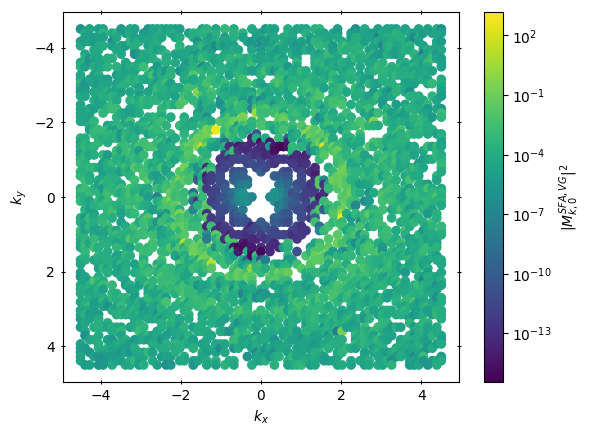

In [9]:
plt_pkl_diff("A2_is_0_15_windows.pkl", "Standard.pkl", log=True)

### Standard values

In [10]:
I = 5e13
convertion_I_au = 3.51e16
I_au = I / convertion_I_au
F_0 = np.sqrt(I_au)

conversion_ev_au = 27.21
w_800 = 1.56 / conversion_ev_au
w_s = w_800 * 800 / 400 # 300 nm

A_0_s = F_0 / w_s

E_0_s = -13.6 / conversion_ev_au

N_s = 30
T_C_s = 2 * np.pi / w_s
T_s = N_s * T_C_s

phase_s = 0.5
epsilon_s = 0.5
A_0_s, A_0_s**2

(0.32915874037472703, 0.10834547636507695)

In [11]:
k_test = np.array([1, 1, 0])

val = M_SFA_VG(t_f=T_s, t_0=0, k=k_test, w_sim=w_s, A_0=A_0_s, E_0=E_0_s, phase=phase_s,
         epsilon=epsilon_s, T_f=T_s)

In [12]:
M_SFA_VG_old(t_f=T_s, t_0=0, k=k_test, w_sim=w_s, A_0=A_0_s, E_0=E_0_s, phase=phase_s,
         epsilon=epsilon_s, T_f=T_s)

/Users/mikkelsewerin/Library/Caches/pypoetry/virtualenvs/test-Mhj20Io5-py3.12/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:446: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  re_retval = quad(refunc, a, b, args, full_output, epsabs,
/Users/mikkelsewerin/Library/Caches/pypoetry/virtualenvs/test-Mhj20Io5-py3.12/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:449: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  im_retval = quad(imfunc, a, b, args, full_output, epsabs,
/Users/mikkelsewerin/Library/Caches/pypoetry/virtualenvs/test-Mhj20Io5-py3.12/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:449: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontin

(0.22221674532096103-0.1614724743964989j)

In [14]:
M_SFA_VG(t_f=T_s, t_0=0, k=k_test, w_sim=w_s, A_0=A_0_s, E_0=E_0_s, phase=phase_s,
         epsilon=epsilon_s, T_f=T_s)

(-0.006758843263566925+0.001707217076256656j)

In [15]:
val

(-0.006758843263566925+0.001707217076256656j)

In [16]:
# complex_func=True for scipy
val.real, val.imag, val

(-0.006758843263566925,
 0.001707217076256656,
 (-0.006758843263566925+0.001707217076256656j))

In [17]:
dp_dk(val)

4.859655240692632e-05

In [18]:
# complex_func=False for scipy
val.real, val.imag, val

(-0.006758843263566925,
 0.001707217076256656,
 (-0.006758843263566925+0.001707217076256656j))

In [19]:
A_0_s, A_0_s**2

(0.32915874037472703, 0.10834547636507695)

In [20]:
dp_dk(val)

4.859655240692632e-05

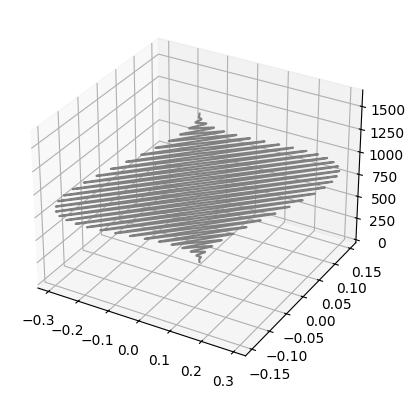

In [21]:
ts = np.linspace(0, T_s, 1000)
Ax_vals = [A_x(t, T_s, w_s, phase_s, epsilon_s, A_0_s) for t in ts]
Ay_vals = [A_y(t, T_s, w_s, phase_s, epsilon_s, A_0_s) for t in ts]

all_vals = [[A_x(t, T_s, w_s, phase_s, epsilon_s, A_0_s), 
             A_y(t, T_s, w_s, phase_s, epsilon_s, A_0_s)] for t in ts]
ax = plt.axes(projection='3d')
# ax.scatter3D(Ax_vals, Ay_vals, ts, c=ts, cmap='Greens')
ax.plot3D(Ax_vals, Ay_vals, ts, 'grey')
plt.show()

In [25]:
tic = datetime.datetime.now()
def compute_values(kx, kys, T_s, w_s, A_0_s, E_0_s, phase_s):
    return [dp_dk(M_SFA_VG(t_f=T_s, t_0=0, k=np.array([kx, ky, 0]), w_sim=w_s, A_0=A_0_s, E_0=E_0_s, 
                       phase=phase_s,
                       epsilon=0.5, T_f=T_s)) for ky in kys]

length = 10

start_val_x = -4.5
end_val_x = 4.5

start_val_y = -4.5
end_val_y = 4.5

kxs = np.linspace(start_val_x, end_val_x, length)
kys = np.linspace(start_val_y, end_val_y, length)

# Create a pool of worker processes using pathos
pool = ProcessingPool()  

# Create a partial function with fixed arguments except for kx
partial_compute_values = partial(
    compute_values, kys=kys, T_s=T_s, w_s=w_s, A_0_s=A_0_s, E_0_s=E_0_s, phase_s=phase_s)

# Map the partial function to kxs
results = pool.map(partial_compute_values, kxs)

kx_plot = np.repeat(kxs, length)
ky_plot = np.tile(kys, length)
values_plot = np.concatenate(results)

toc = datetime.datetime.now()
print(f"Finished, length: {length}, time: {toc - tic}")


Finished, length: 10, time: 0:01:19.842206


Functions, time: 25.381660 length: 10
Quads, time: 1:27.857284 length: 10 3.6 forbedring 

In [ ]:
fig, ax = plt.subplots()
im = ax.scatter(kx_plot, ky_plot, c=values_plot, norm=LogNorm())

ax.set(xlabel=r"$k_x$", ylabel=r"$k_y$")
ax.tick_params(direction="inout", right=True, top=True)

cbar = fig.colorbar(im, ax=ax, label=r'$|M^{SFA, VG}_{k, 0}|^2$')
cbar.ax.set_ylabel('Log scale')

plt.show()

### Old method

In [ ]:
values_plot

In [ ]:
fig, ax = plt.subplots()
im = ax.scatter(kx_plot, ky_plot, c=values_plot)

ax.tick_params(direction="inout", right=True, top=True)
ax.set(xlabel=r"$k_x$", ylabel=r"$k_y$")

fig.colorbar(im, ax=ax, label=r'$|M^{SFA, VG}_{k, 0}|^2$')

In [ ]:
kx_plot

In [ ]:
df = pd.DataFrame()
df["kx"] = kx_plot
df["ky"] = ky_plot
df["dpdk"] = values_plot
df.to_pickle("Standard.pkl")

In [ ]:
df.loc[df["dpdk"] < 1]

In [ ]:
max_val = 1
plot(df.loc[df["dpdk"] < max_val, "kx"], 
     df.loc[df["dpdk"] < max_val, "ky"], df.loc[df["dpdk"] < max_val, "dpdk"])

In [ ]:
plt_pkl("0002_windows.pkl", log=True)

In [ ]:
df_std = pd.read_pickle("Standard.pkl")

In [ ]:
df_std.loc[df_std["dpdk"] < 0.01, "dpdk"].sum()

In [ ]:
plt.rcParams['figure.figsize'] = (12, 10)  # Change the numbers to adjust width and height

#plt_pkl("A2_is_0_15_windows.pkl", log=True)
plt_pkl("Standard.pkl", log=True)
plt_pkl("Standard.pkl", log=False)

In [ ]:
plt_pkl_diff("A2_is_0_15_windows.pkl", "Standard.pkl", log=True)

In [ ]:
plt_pkl("A2_is_0_15_windows.pkl", log=True)

In [ ]:
plt_pkl("ws_er_2ws_19_windows.pkl", log=True)

In [ ]:
plt_pkl("I_er_e14_23_windows.pkl", log=True)

In [ ]:
dd = pd.read_pickle("0002_windows.pkl")

In [ ]:
dd.loc[dd["kx"]==0]

In [ ]:
plot_log(df.loc[df["dpdk"] < 1, "kx"], df.loc[df["dpdk"] < 1, "ky"], df.loc[df["dpdk"] < 1, "dpdk"])

length = 5
start_val = -4
end_val = 4
kxs = np.linspace(start_val, end_val, length)
kys = np.linspace(start_val, end_val, length)



kx_plot = []
ky_plot = []
values_plot = []
for i, kx in enumerate(kxs):
    values = [dp_dk(M_SFA_VG(t_f=T_s, t_0=0, k=np.array([kx, ky, 0]), w_sim=w_s, A_0=A_0_s, E_0=E_0_s, 
                       phase=phase_s,
                       epsilon=0.5, T_f=T_s)) for ky in kys]
    print(i)
    kx_plot.extend(kx * np.ones(length))
    ky_plot.extend(kys)
    values_plot.extend(values)
        